In [6]:
import abacus_cosmos.Halos as ach
from astropy.table import Table
import matplotlib.pyplot as plt
import astropy.cosmology as apc
import os
import numpy as np
import glob
from astropy import constants as const
from collections import Counter
%matplotlib inline

In [7]:
dtype=[('BoxID','i8'), ('hubble', 'f8'), ('omega_de', 'f8'),
      ('omega_m', 'f8'), ('n_s', 'f8'), ('sigma_8', 'f8'), ('w_0', 'f8')]
cosmo_data = np.loadtxt("../abacus/box_cosmo_params.dat", dtype=dtype)

In [42]:
def get_sphere(box_id=0):
    main_path = "/Users/forero/data/AbacusCosmos/"
    halo_path = "AbacusCosmos_720box_{:02d}_FoF_halos_z0.100".format(box_id)
    halo_data = Table(ach.read_halos_FoF(os.path.join(main_path,halo_path)))

    vcirc_max_limit = 300.0
    r_limit = 300
    hubble = cosmo_data['hubble'][box_id]/100
    halo_data['r'] = np.sqrt(np.sum(halo_data['pos']**2, axis=1))
    halo_data['r'] = halo_data['r']/hubble

    ii = (halo_data['r']<r_limit) & (halo_data['vcirc_max']>vcirc_max_limit)
    print(box_id, np.count_nonzero(ii))
    sphere_data = halo_data['pos'][ii]/hubble

    np.savetxt("../abacus/sphere_{:02d}.dat".format(box_id), sphere_data)
    del halo_data
    del sphere_data

In [43]:
for i in range(40):
    get_sphere(box_id=i)

0 24883
1 21023
2 23716
3 27634
4 26775
5 28377
6 20890
7 20718
8 18964
9 26608
10 26550
11 24313
12 23310
13 23795
14 30845
15 20542
16 24130
17 20210
18 25856
19 25510
20 22403
21 27068
22 27550
23 24557
24 28455
25 23201
26 25113
27 19907
28 23188
29 26479
30 21403
31 27727
32 17613
33 22760
34 28579
35 31370
36 23151
37 23138
38 24717
39 25304


In [30]:
halo_data['r'].max()

901.1739

In [31]:
print(len(halo_data))
halo_data[:5]

5679757


id,subsamp_start,subsamp_len,N,subhalo_N [4],pos [3],vel [3],sigma_v [3],r25,r50,r75,r90,vcirc_max,rvcirc_max,subhalo_pos [3],subhalo_vel [3],subhalo_sigma_v [3],subhalo_r25,subhalo_r50,subhalo_r75,subhalo_r90,subhalo_vcirc_max,subhalo_rvcirc_max,r
int64,uint64,uint32,uint32,uint32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
33242377525485,0,6042,61014,46133 .. 119,-291.64633 .. -105.28595,531.88684 .. -288.55768,990.00824 .. 689.22723,0.5004687,0.8660907,1.3230082,1.6626426,1325.5693,0.9514289,-291.61087 .. -105.30351,546.17084 .. -291.6522,990.0122 .. 689.3368,0.5034659,0.86499655,1.3266732,1.6629909,1325.9965,0.9682756,671.18317
33242377525486,6042,5083,50385,31713 .. 247,-206.92566 .. -6.3978934,-219.40858 .. 244.34375,879.3337 .. 717.94214,0.39124697,0.749892,1.2458961,1.7974755,1302.3759,0.62463725,-206.91232 .. -6.431199,-282.6682 .. 279.06,879.406 .. 718.5126,0.39412794,0.74887997,1.2393483,1.8023514,1301.213,0.6082665,598.57074
33242377525487,11125,4825,47735,30587 .. 337,-334.5504 .. -288.83307,-45.89861 .. 205.59645,956.1997 .. 592.95807,0.4907872,0.82340205,1.2359469,1.6911743,1207.1226,0.9759423,-334.46967 .. -288.86816,-63.36762 .. 202.89743,958.4737 .. 592.9798,0.46223176,0.8068678,1.2255337,1.7440823,1210.776,1.0073159,814.5842
33242377525488,15950,3649,36377,18177 .. 1219,-242.45346 .. -96.391716,-96.9405 .. -300.62143,683.35156 .. 538.44244,0.7287632,1.0945324,1.5920411,2.255294,926.70776,1.4882649,-242.84319 .. -96.34182,-35.0495 .. -278.4491,713.2138 .. 540.1599,0.4893169,0.89087886,1.8182843,2.955047,1006.18494,0.8818925,631.3885
33242377525489,19599,3101,31168,21245 .. 168,-207.48279 .. 127.62681,261.48892 .. -454.914,794.4296 .. 524.00366,0.48423404,0.8357953,1.3439658,1.7923307,963.45374,0.90488607,-207.53146 .. 127.66963,282.2734 .. -492.08057,795.8885 .. 524.26013,0.5169864,0.85581833,1.3603778,1.7637129,953.46,0.9570152,622.68555


682260


In [49]:
halo_data['r'] = np.sqrt(np.sum(halo_data['pos']**2, axis=1))
halo_data['theta'] = np.rad2deg(np.arccos(halo_data['pos'][:,2]/halo_data['r']))
halo_data['phi'] = np.rad2deg(np.arctan2(halo_data['pos'][:,1], halo_data['pos'][:,0]))
halo_data['norm_v'] = np.sqrt(np.sum(halo_data['vel']**2, axis=1))
halo_data['v_radial'] = np.sum(halo_data['pos']*halo_data['vel'], axis=1)/halo_data['r']
halo_data['z_RSD'] = halo_data['v_radial']/const.c.to('km/s')

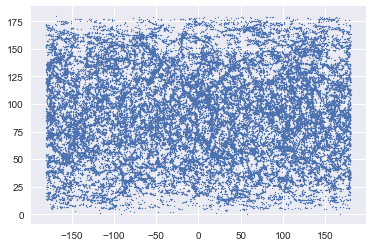

In [44]:
ii_r = (halo_data['r']>250) & (halo_data['r']<255.0)
plt.scatter(halo_data['phi'][ii_r], halo_data['theta'][ii_r], s=1.0)

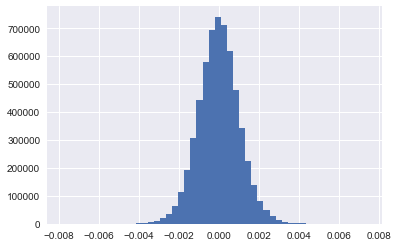

In [50]:
_ = plt.hist(halo_data['z_RSD'], bins=50)

In [52]:
planck15 = apc.Planck15
apc.z_at_value()
halo_data['z_cosmo'] = planck15.z (gal_data['redshift'])


his works for any arbitrary input cosmology, but is inefficient
if you want to invert a large number of values for the same
cosmology. In this case, it is faster to instead generate an array
of values at many closely-spaced redshifts that cover the relevant
redshift range, and then use interpolation to find the redshift at
each value you're interested in. For example, to efficiently find
the redshifts corresponding to 10^6 values of the distance modulus
in a Planck13 cosmology, you could do the following:

>>> import astropy.units as u
>>> from astropy.cosmology import Planck13, z_at_value

Generate 10^6 distance moduli between 24 and 43 for which we
want to find the corresponding redshifts:

>>> Dvals = (24 + np.random.rand(1e6) * 20) * u.mag

Make a grid of distance moduli covering the redshift range we
need using 50 equally log-spaced values between zmin and
zmax. We use log spacing to adequately sample the steep part of
the curve at low distance moduli:

>>> zmin = z_at_value(Planck13.distmod, Dvals.min())
>>> zmax = z_at_value(Planck13.distmod, Dvals.max())
>>> zgrid = np.logspace(np.log10(zmin), np.log10(zmax), 50)
>>> Dgrid = Planck13.distmod(zgrid)

Finally interpolate to find the redshift at each distance modulus:

>>> zvals = np.interp(Dvals.value, zgrid, Dgrid.value)

Examples
--------
>>> import astropy.units as u
>>> from astropy.cosmology import Planck13, z_at_value

The age and lookback time are monotonic with redshift, and so a
unique solution can be found:

>>> z_at_value(Planck13.age, 2 * u.Gyr)
3.19812268...

The angular diameter is not monotonic however, and there are two
redshifts that give a value of 1500 Mpc. Use the zmin and zmax keywords
to find the one you're interested in:

>>> z_at_value(Planck13.angular_diameter_distance, 1500 * u.Mpc, zmax=1.5)
0.6812769577...
>>> z_at_value(Planck13.angular_diameter_distance, 1500 * u.Mpc, zmin=2.5)
3.7914913242...